<a href="https://colab.research.google.com/github/stefanoubrook/timaeus-mnist-llc/blob/main/LLC_Experiment_Brook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investigating Local Learning Coefficients (LLC) Dynamics in MNIST**

### **Objective**
I aim to replicate the developmental stages of training by monitoring the Local Learning Coefficient (LLC) during standard SGD optimization.

### **Theory**
In Singular Learning Theory (SLT), the complexity of a model is not defined by its parameter count $d$, but by its effective dimension or LLC, denoted as $\widehat{\lambda}$.

In regular Models $\lambda \approx d/2$ and in Singular Models (Deep Learning) $\lambda \ll d/2$.

A lower $\widehat{\lambda}$ indicates a "flatter," more singular geometry in the loss landscape.

### **Method**
I monitor the training trajectory of a simple MLP. Periodically, we pause optimization to estimate the local volume of the basin using SGLD (Stochastic Gradient Langevin Dynamics).

In [1]:
# setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from devinterp.slt.sampler import sample, LLCEstimator
from devinterp.optim.sgld import SGLD

# configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loss for a batch
def evaluate_fn(model, data):
    inputs, targets = data

    # move to gpu
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

    return criterion(model(inputs), targets)

### **The System**

Define a Multi-Layer Perceptron (MLP) to learn the MNIST manifold.

* Input Space: $\mathbb{R}^{784}$ (Flattened $28 \times 28$ image).
* Hidden Layer: $\mathbb{R}^{128}$ with ReLU activation.
* Output: $\mathbb{R}^{10}$ (Logits).

While the parameter space has a fixed dimension $d \approx 100,000$, the effective dimension will vary as the model traverses the landscape. I expect $\widehat{\lambda}$ to deviate significantly from the theoretical maximum as the network discovers symmetries in the data.

In [2]:
# data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# model
class SimpleNet(nn.Module):
    def __init__(self, hidden_width=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden_width),
            nn.ReLU(),
            nn.Linear(hidden_width, 10)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleNet(hidden_width=128).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()



# LLC data
history = {
    "step": [],
    "loss": [],
    "llc": []
}

### **The Dynamics**

I perform standard SGD updates to minimize the Cross Entropy Loss. To estimate the local complexity $\widehat{\lambda}$ at step $t$, I employ the WBIC (Widely Applicable Bayesian Information Criterion) estimator via SGLD.

The Estimation Process:
1.  Pause the main training trajectory.
2.  Initiate a short SGLD chain. This injects Gaussian noise to "explore" the local basin.
3.  Compare the average loss of the noisy chain against the loss at the center.

In [3]:
global_step = 0
total_steps_needed = 2500
model.train()
while global_step < total_steps_needed:
  for step, (data, targets) in enumerate(train_loader):
      if global_step > total_steps_needed:
            break

      data, targets = data.to(DEVICE), targets.to(DEVICE)

      # standard training
      optimizer.zero_grad()
      loss = criterion(model(data), targets)
      loss.backward()
      optimizer.step()

      # measure LLC every 100 steps
      if step % 100 == 0:
          # calculate initial loss
          model.eval()
          with torch.no_grad():
              init_loss = 0
              eval_data, eval_targets = next(iter(train_loader))
              eval_data, eval_targets = eval_data.to(DEVICE), eval_targets.to(DEVICE)
              init_loss = criterion(model(eval_data), eval_targets).item()
          model.train()


          # create estimator
          llc_estimator = LLCEstimator(
              num_chains=1,
              num_draws=40,
              nbeta=2.0,
              init_loss=init_loss
          )

          # run the sampler (adding gaussian noise)
          trace = sample(
              model,
              train_loader,
              evaluate=evaluate_fn,
              optimizer_kwargs=dict(lr=0.001, nbeta=2.0),
              sampling_method=SGLD,
              num_chains=1,
              num_draws=40,
              num_burnin_steps=100,
              num_steps_bw_draws=1,
              callbacks=[llc_estimator],
              device=DEVICE,
              verbose=False
          )

          # results
          current_llc = trace["llc/mean"]

          history["step"].append(global_step)
          history["loss"].append(loss.item())
          history["llc"].append(current_llc)
          print(f"Measurment Complete: Step {global_step} | Loss: {loss.item():.4f} | LLC: {current_llc:.4f}")

      global_step += 1

/usr/local/lib/python3.12/dist-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/devinterp/slt/llc.py:109: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.llc_std = self.llc_per_chain.std()


Measurment Complete: Step 0 | LLC: 31.6425
Measurment Complete: Step 100 | LLC: 35.2087
Measurment Complete: Step 200 | LLC: 32.5057
Measurment Complete: Step 300 | LLC: 31.0842
Measurment Complete: Step 400 | LLC: 28.2029
Measurment Complete: Step 469 | LLC: 28.6692
Measurment Complete: Step 569 | LLC: 29.8028
Measurment Complete: Step 669 | LLC: 24.7681
Measurment Complete: Step 769 | LLC: 25.9321
Measurment Complete: Step 869 | LLC: 30.7093
Measurment Complete: Step 938 | LLC: 29.8588
Measurment Complete: Step 1038 | LLC: 26.8684
Measurment Complete: Step 1138 | LLC: 26.5941
Measurment Complete: Step 1238 | LLC: 23.3471
Measurment Complete: Step 1338 | LLC: 28.0151
Measurment Complete: Step 1407 | LLC: 29.2719
Measurment Complete: Step 1507 | LLC: 30.7710
Measurment Complete: Step 1607 | LLC: 27.1076
Measurment Complete: Step 1707 | LLC: 29.5145
Measurment Complete: Step 1807 | LLC: 28.6169
Measurment Complete: Step 1876 | LLC: 28.6922
Measurment Complete: Step 1976 | LLC: 30.8392
M

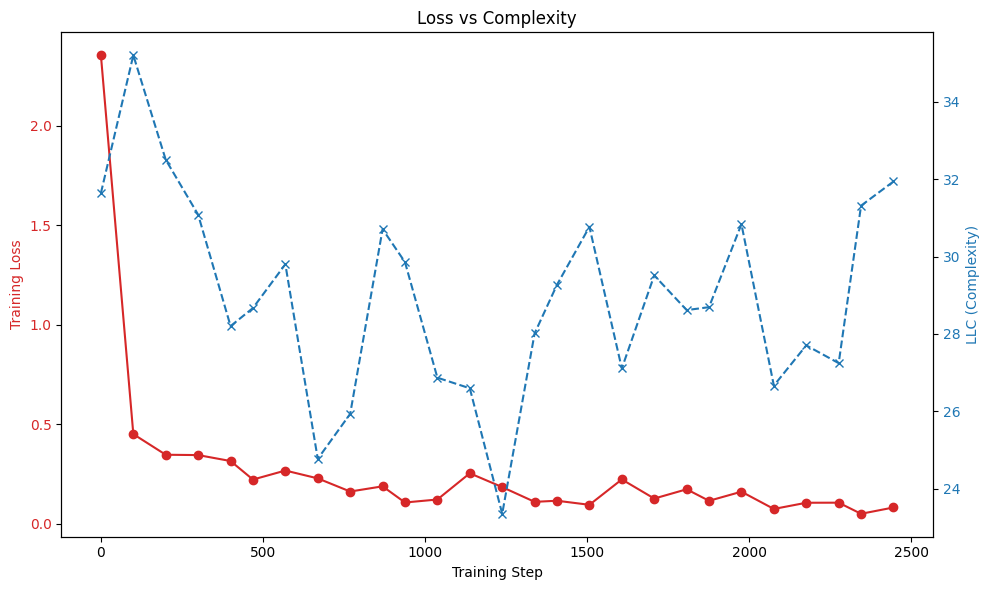

In [4]:
# visualisation
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(history["step"], history["loss"], color=color, marker='o', label="Loss")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('LLC (Complexity)', color=color)
ax2.plot(history["step"], history["llc"], color=color, marker='x', linestyle='--', label="LLC")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Loss vs Complexity")
fig.tight_layout()
plt.show()

### **Analysis**

**Loss vs. Complexity**
The graph above visualizes the decoupling of performance (Loss) and structure (LLC). While the training loss (Red) decreases monotonically and approaches zero, the Local Learning Coefficient (Blue) reveals a non-monotonic trajectory, indicating that geometric complexity changes independently of error reduction.

**Phase Transitions**

**Compression (Steps 0–1200)**:

The effective dimension drops significantly. This suggests the model initially simplified its internal representation, collapsing into a more singular solution to capture the dominant features of the data.

Expansion (Steps 1200+):

Post-collapse, the complexity rises again to stabilize. This likely corresponds to the model re-introducing complexity to memorize residual edge cases or fine-tune the solution once the broad structure was learned.

**Conclusion**

This experiment confirms that the effective parameter count is a dynamic quantity. The divergence between the Loss and LLC trajectories—specifically the "dip" in complexity while loss is still falling—supports the Timaeus hypothesis that geometric measures can detect structural changes.